# 2 Data

In [439]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import wrds
#db=wrds.Connection(wrds_username='sahakyan')

# 3 Betting against Beta strategy (BaB)

#### (a) Computation of time-varying Beta

In [440]:
# columns = [ 'NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth', 'Money', 'Other']
industry_column_name = 'Other'
# load data
data = pd.read_csv('data_with_industries.csv', sep=',', encoding='utf-8')
data = data[data[industry_column_name] == 1]
# drop last 12 columns
data = data.iloc[:, :-12]

# drop columns with missing values
data['date'] = pd.to_datetime(data['date'])
# get rid of the day in the date
data['date'] = data['date'].dt.to_period('M')
data['date'] = data['date'].dt.to_timestamp()

In [441]:
data = data.sort_values(by=['permno', 'date']).reset_index(drop=True)

In [442]:
# (a)
# 0. Remove nans
data = data.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

# 2. Estimate Rolling Betas
cov_nm = data.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(window = 60, min_periods=36).cov()
beta_n = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))
beta_n = beta_n.dropna().reset_index().rename(columns={'Rm_e':'beta'})

# 3. Merge betas with data
beta_n['date'] = beta_n['date'] + pd.DateOffset(months=1)
data = data.merge(beta_n, on=['permno','date'], how='left')

# get rid of nan values
data = data.dropna(subset=['beta']).copy()

# 4. Remove outliers
data['beta'] = data['beta'].clip(data['beta'].quantile(0.05),data['beta'].quantile(0.95))

In [443]:
len(data)

130869

#### (B) Beta Deciles

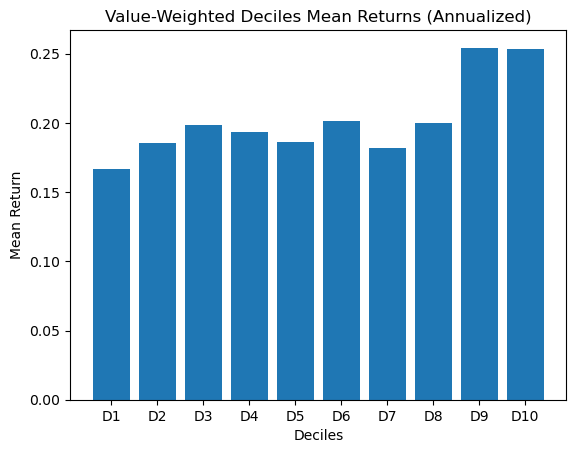

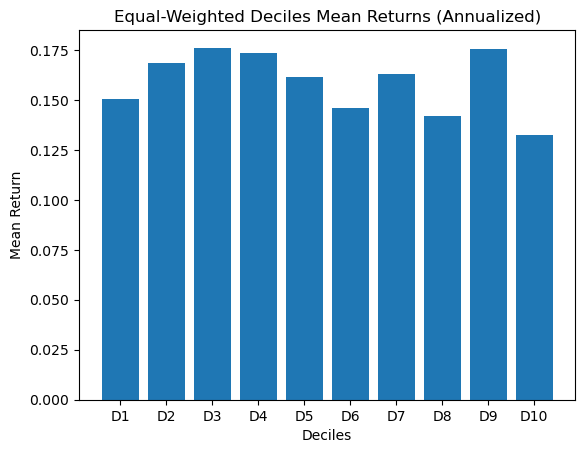

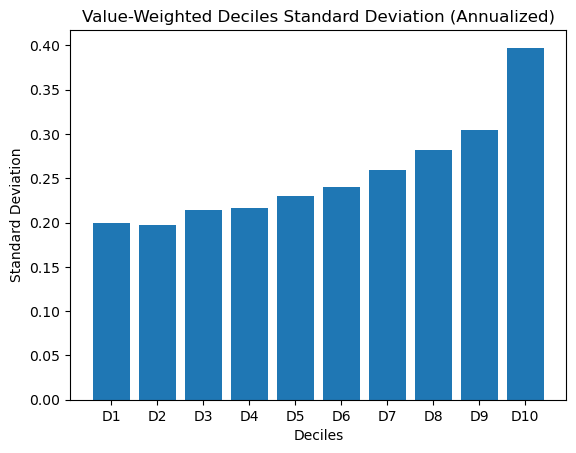

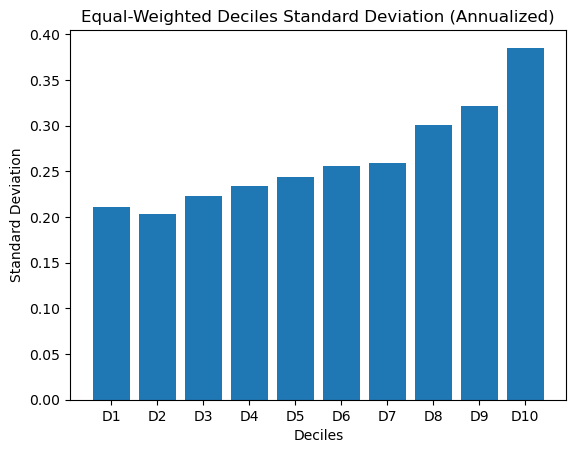

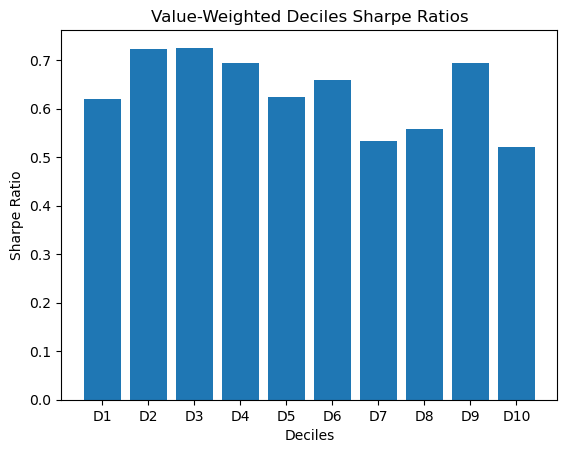

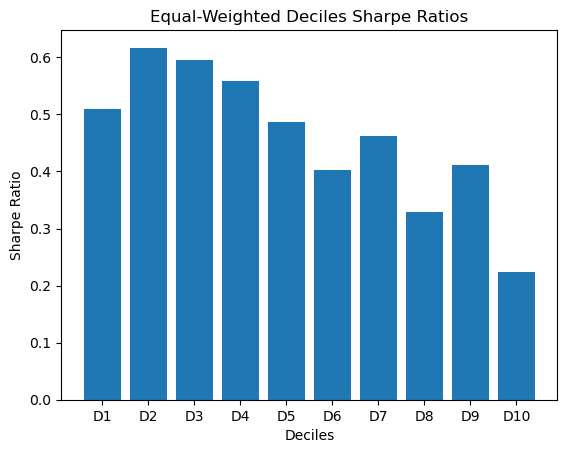

In [444]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# (b)
# 1. Deciles
data['beta_Q'] = data.groupby('date')['beta'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))
# 2. Market Weights within deciles
data['vw_Q'] = data['mcap'] / data.groupby(['date', 'beta_Q'])['mcap'].transform('sum')

# 3. VW Portfolios
data['beta_ret_vw'] = data['vw_Q'] * data['Rn']
ret_vw = data.groupby(['date', 'beta_Q'])['beta_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('beta_Q')['beta_ret_vw'].mean()

# 4. Equal-Weighted portfolios
ret_ew = data.groupby(['date', 'beta_Q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('beta_Q')['Rn'].mean()

# Calculate standard deviations
vw_ret_std = ret_vw.groupby('beta_Q')['beta_ret_vw'].std()
ew_ret_std = ret_ew.groupby('beta_Q')['Rn'].std()

# Compute the Sharpe Ratios for each decile

# compute the risk-free rate
rf = data.groupby(['date', 'beta_Q'])['rf'].mean().reset_index()

# compute the excess returns
ret_vw['excess'] = ret_vw['beta_ret_vw'] - rf['rf']
ret_ew['excess'] = ret_ew['Rn'] - rf['rf']

# compute the Sharpe Ratios
vw_sharpe = ret_vw.groupby('beta_Q')['excess'].mean() / ret_vw.groupby('beta_Q')['beta_ret_vw'].std()
ew_sharpe = ret_ew.groupby('beta_Q')['excess'].mean() / ret_ew.groupby('beta_Q')['Rn'].std()

# 5. Plot Histograms
deciles = ['D' + str(x) for x in np.arange(1, 11)]

directory = 'Plots/Part3'

#save plots
# Plot VW mean returns
plt.bar(deciles, vw_ret_mean * 12)
plt.title('Value-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.show()

# Plot EW mean returns
plt.bar(deciles, ew_ret_mean * 12)
plt.title('Equal-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.show()

# Plot VW standard deviations
plt.bar(deciles, vw_ret_std * np.sqrt(12))
plt.title('Value-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.show()

# Plot EW standard deviations
plt.bar(deciles, ew_ret_std * np.sqrt(12))
plt.title('Equal-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.show()

# Plot VW Sharpe Ratios
plt.bar(deciles, vw_sharpe* np.sqrt(12))
plt.title('Value-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.show()

# Plot EW Sharpe Ratios
plt.bar(deciles, ew_sharpe* np.sqrt(12))
plt.title('Equal-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.show()

TODO
- Question: Summarize our findings. Is the evidence consistent with the CAPM?
- Answer:

#### (c/d) Construct BAB factor

In [445]:
# Weights
data['z'] = data.groupby('date')['beta'].transform(lambda x: x.rank())
data['z_'] = data['z']-data.groupby('date')['z'].transform('mean')
data['k'] = np.abs(data['z_'])
data['k'] = 2/data.groupby('date')['k'].transform('sum')
data['w_H'] = data['k'] * data['z_'] * (data['z_']>0) 
data['w_L'] = -data['k'] * data['z_'] * (data['z_']<0) 

# Weighted returns and beta
data['beta_H'] = data['w_H'] * data['beta']
data['beta_L'] = data['w_L'] * data['beta']
data['R_H'] = data['w_H'] * data['Rn']
data['R_L'] = data['w_L'] * data['Rn']
data['R_H_e'] = data['w_H'] * data['Rn_e']
data['R_L_e'] = data['w_L'] * data['Rn_e']

# Sum up the weighted returns and betas but not the rf
BAB = data.groupby('date')[['R_H','R_L','R_H_e','R_L_e','beta_H','beta_L']].sum().reset_index()
BAB['rf'] = data.groupby('date')['rf'].mean().reset_index()['rf']
# unlevered returns
BAB['BAB2'] = (BAB['R_L_e']/BAB['beta_L']) - ( BAB['R_H_e']/BAB['beta_H'] )


In [446]:
# Merge Market and Risk free Rate
tmp = pd.merge(BAB,data[['date','Rm_e']].drop_duplicates(), on=['date'], how='left')
tmp['alpha'] = 1

# Alpha and Beta
import statsmodels.api as sm
tmp = tmp.dropna()
OLS_Reg = sm.OLS(tmp['BAB2'], tmp[['alpha','Rm_e']]).fit()

# Report the mean,standard deviation, and sharpe ratio and CAPM alpha of the BAB factor
print('Mean:', tmp['BAB2'].mean()*12)
print('Standard Deviation:', tmp['BAB2'].std()*np.sqrt(12))
# Annualize the Sharpe ratio and CAPM alpha
print('Sharpe ratio:', tmp['BAB2'].mean()/tmp['BAB2'].std()*np.sqrt(12))
print('Monthly CAPM Alpha:', OLS_Reg.params['alpha']*12)



Mean: 0.1261777434072223
Standard Deviation: 0.17974435731951277
Sharpe ratio: 0.7019844477394598
Monthly CAPM Alpha: 0.08849652838145765


Save factor for our investing strategy

In [447]:
print(len(BAB))
strat = BAB[['date','rf','BAB2']]
strat

682


,date,rf,BAB2
0,1967-01-01,0.003788,0.116868
1,1967-02-01,0.003737,0.047624
2,1967-03-01,0.003385,0.024018
3,1967-04-01,0.002877,-0.008473
4,1967-05-01,0.002707,0.072787
...,...,...,...
677,2023-08-01,0.004463,0.003286
678,2023-09-01,0.004472,-0.032719
679,2023-10-01,0.004475,0.041248
680,2023-11-01,0.004455,0.020435


# 4 Momentum Strategy (Mom)

In [448]:
# Load data
data = pd.read_csv('data_with_industries.csv', sep=',')
data = data[data[industry_column_name] == 1]
# drop last 12 columns
data = data.iloc[:, :-12]
#drop column mcap_l 
data = data.drop(columns=['mcap_l'])
#drop nan in Rn column
data = data.dropna(subset=['Rn'])
# Convert date to datetime
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.to_period('M')
data['date'] = data['date'].dt.to_timestamp()
# Sort the data by permno and date
data = data.sort_values(['permno', 'date']).reset_index(drop=True)
display(data.isna().sum())
data

permno      0
date        0
Rn          0
shrout      0
prc         0
SIC         0
mcap        0
rf        239
Rm          0
const       0
Rn_e      239
Rm_e      239
dtype: int64

,permno,date,Rn,shrout,prc,SIC,mcap,rf,Rm,const,Rn_e,Rm_e
0,10029,1987-12-01,0.076923,3464.0,5.2500,8299,18186.00,0.003072,0.070324,1,0.073851,0.067252
1,10029,1988-01-01,-0.035714,3464.0,-5.0625,8299,17536.50,0.004404,0.044875,1,-0.040118,0.040471
2,10029,1988-02-01,-0.061728,3464.0,-4.7500,8299,16454.00,0.004310,0.051691,1,-0.066038,0.047381
3,10029,1988-03-01,0.026316,3464.0,4.8750,8299,16887.00,0.004778,-0.016598,1,0.021538,-0.021376
4,10029,1988-04-01,0.000000,3464.0,-4.8750,8299,16887.00,0.004795,0.010993,1,-0.004795,0.006198
...,...,...,...,...,...,...,...,...,...,...,...,...
186061,93423,2023-08-01,-0.039331,83520.0,22.9600,7389,1917619.20,0.004463,-0.020605,1,-0.043794,-0.025068
186062,93423,2023-09-01,0.023955,83520.0,23.5100,7389,1963555.20,0.004472,-0.047390,1,0.019483,-0.051862
186063,93423,2023-10-01,-0.153552,83520.0,19.9000,7389,1662048.00,0.004475,-0.028867,1,-0.158027,-0.033342
186064,93423,2023-11-01,0.251256,83537.0,24.9000,7389,2080071.30,0.004455,0.092057,1,0.246801,0.087602


In [449]:
data['LN_Cret12'] = data.groupby('permno').apply(lambda x: np.log(x.Rn+1).rolling(11, min_periods = 11, closed='left').sum()).values

# shift the LN_Cret12 column by 1
data['LN_Cret12'] = data.groupby('permno')['LN_Cret12'].shift(1)
data.dropna(subset=['LN_Cret12'], inplace=True)

q = 10
data['Momentum'] = data.groupby('date')['LN_Cret12'].transform(lambda x: pd.qcut(x,q,labels=False, duplicates='drop'))
data

,permno,date,Rn,shrout,prc,SIC,mcap,rf,Rm,const,Rn_e,Rm_e,LN_Cret12,Momentum
12,10029,1988-12-01,-0.056180,3284.0,-5.250,8299,17241.00,0.005509,0.021071,1,-0.061689,0.015562,0.186587,4
13,10029,1989-01-01,0.047619,3284.0,5.500,8299,18062.00,0.006569,0.066101,1,0.041050,0.059532,0.057820,4
14,10029,1989-02-01,-0.068182,3284.0,5.125,8299,16830.50,0.006280,-0.016442,1,-0.074462,-0.022722,0.036368,4
15,10029,1989-03-01,-0.073171,3289.0,4.750,8299,15622.75,0.007313,0.021465,1,-0.080484,0.014152,0.146603,5
16,10029,1989-04-01,-0.105263,3289.0,-4.250,8299,13978.25,0.007134,0.048207,1,-0.112397,0.041073,0.050009,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186061,93423,2023-08-01,-0.039331,83520.0,22.960,7389,1917619.20,0.004463,-0.020605,1,-0.043794,-0.025068,0.136284,6
186062,93423,2023-09-01,0.023955,83520.0,23.510,7389,1963555.20,0.004472,-0.047390,1,0.019483,-0.051862,0.076040,4
186063,93423,2023-10-01,-0.153552,83520.0,19.900,7389,1662048.00,0.004475,-0.028867,1,-0.158027,-0.033342,0.260188,5
186064,93423,2023-11-01,0.251256,83537.0,24.900,7389,2080071.30,0.004455,0.092057,1,0.246801,0.087602,0.052838,5


In [450]:
# 2. Market Weights within deciles
data['vw_Q'] = data['mcap']/data.groupby(['date','Momentum'])['mcap'].transform('sum')

# 3. VW Portfolios
data['MOM_ret_vw'] = data['vw_Q']*data['Rn']
ret_vw = data.groupby(['date','Momentum'])['MOM_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('Momentum')['MOM_ret_vw'].mean()

# 4. Equal-Weighted portfolios
ret_ew = data.groupby(['date','Momentum'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('Momentum')['Rn'].mean()

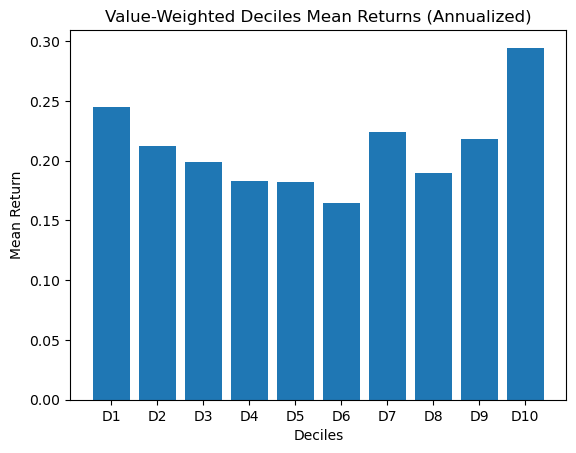

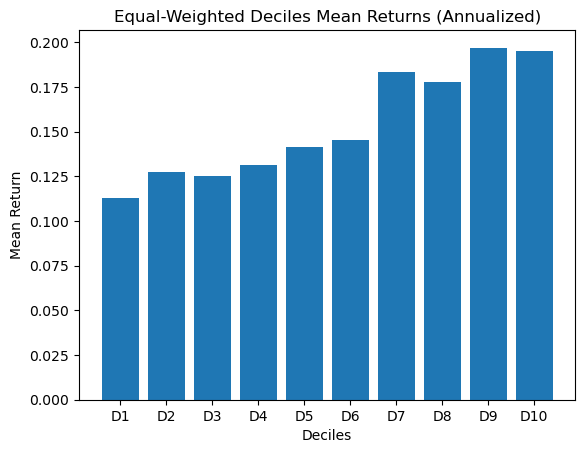

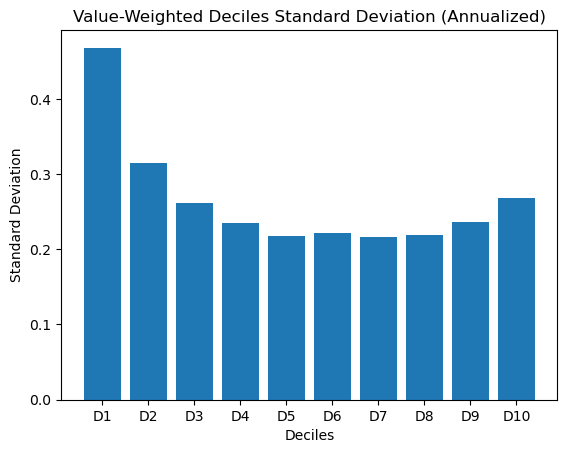

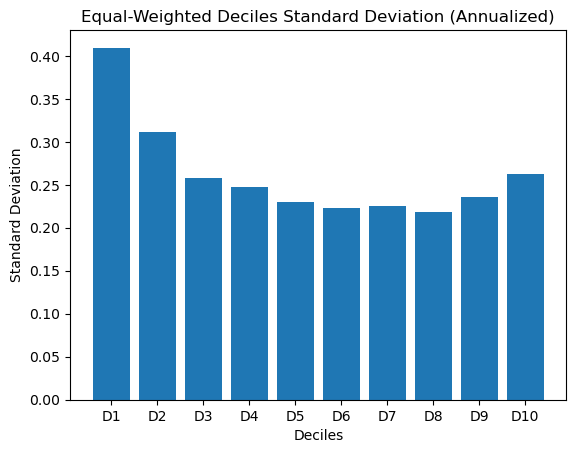

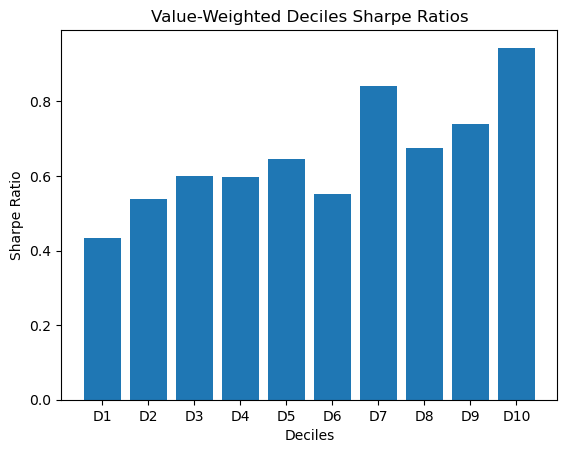

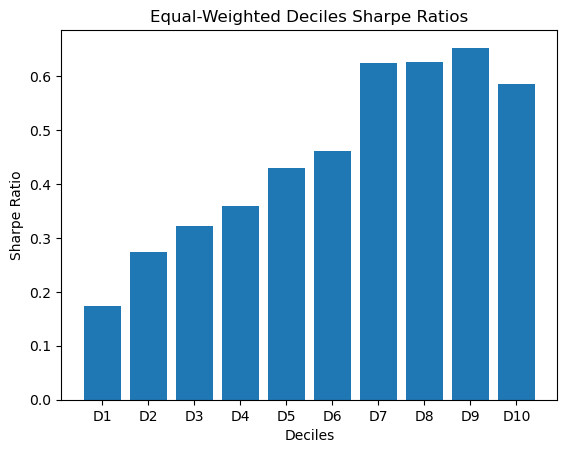

In [451]:
# Calculate standard deviations
vw_ret_std = ret_vw.groupby('Momentum')['MOM_ret_vw'].std()
ew_ret_std = ret_ew.groupby('Momentum')['Rn'].std()

# Calculate Sharpe Ratios

# compute the risk-free rate
rf = data.groupby(['date', 'Momentum'])['rf'].mean().reset_index()

# compute the excess returns
ret_vw['excess'] = ret_vw['MOM_ret_vw'] - rf['rf']
ret_ew['excess'] = ret_ew['Rn'] - rf['rf']

# compute the Sharpe Ratios
vw_sharpe_ratio = ret_vw.groupby('Momentum')['excess'].mean() / vw_ret_std
ew_sharpe_ratio = ret_ew.groupby('Momentum')['excess'].mean() / ew_ret_std


# 5. Plot Histograms
deciles = ['D' + str(x) for x in np.arange(1, 11)]

directory = 'Plots/Part4/'
#save plots
# Plot VW mean returns
plt.bar(deciles, vw_ret_mean * 12)
plt.title('Value-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.show()

# Plot EW mean returns
plt.bar(deciles, ew_ret_mean * 12)
plt.title('Equal-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.show()

# Plot VW standard deviations
plt.bar(deciles, vw_ret_std * np.sqrt(12))
plt.title('Value-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.show()

# Plot EW standard deviations
plt.bar(deciles, ew_ret_std * np.sqrt(12))
plt.title('Equal-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.show()

# Plot VW Sharpe ratios
plt.bar(deciles, vw_sharpe_ratio * np.sqrt(12))
plt.title('Value-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.show()

# Plot EW Sharpe ratios
plt.bar(deciles, ew_sharpe_ratio * np.sqrt(12))
plt.title('Equal-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.show()

### Factor creation

#### Equal-Weighted Long-Short Factor Strategy

In [452]:
# 1. Compute the long and short legs of the strategy
ew_long_leg = data[data['Momentum'] >= 7].groupby('date')['Rn'].mean().reset_index()
ew_short_leg = data[data['Momentum'] < 3].groupby('date')['Rn'].mean().reset_index()

# 2. Compute the excess returns
rf = data.groupby(['date', 'Momentum'])['rf'].mean().reset_index()

ew_long_leg['excess'] = ew_long_leg['Rn'] - rf['rf']
ew_short_leg['excess'] = ew_short_leg['Rn'] - rf['rf']

# 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
long_mean = ew_long_leg['Rn'].mean() * 12
short_mean = ew_short_leg['Rn'].mean() * 12

long_mean_e = ew_long_leg['excess'].mean() * 12
short_mean_e = ew_short_leg['excess'].mean() * 12

long_std = ew_long_leg['Rn'].std() * np.sqrt(12)
short_std = ew_short_leg['Rn'].std() * np.sqrt(12)

long_sharpe_ratio = long_mean_e / long_std
short_sharpe_ratio = short_mean_e / short_std

# Long minus short factor strategy
factor = ew_long_leg.set_index("date") - ew_short_leg.set_index("date")
factor = factor.reset_index()
factor['excess'] = factor['Rn'] - rf['rf']

factor_mean = factor['Rn'].mean() * 12
factor_mean_e = factor['excess'].mean() * 12
factor_std = factor['Rn'].std() * np.sqrt(12)
factor_sharpe_ratio = factor_mean_e / factor_std

# 4. Print the results
print('Long Leg Mean Return:', long_mean)
print('Short Leg Mean Return:', short_mean)
print('Long Leg Standard Deviation:', long_std)
print('Short Leg Standard Deviation:', short_std)
print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
print('Factor Mean Return:', factor_mean)
print('Factor Standard Deviation:', factor_std)
print('Factor Sharpe Ratio:', factor_sharpe_ratio)

Long Leg Mean Return: 0.19018807781489566
Short Leg Mean Return: 0.12166749347923024
Long Leg Standard Deviation: 0.22480141470311799
Short Leg Standard Deviation: 0.3034660761081126
Long Leg Sharpe Ratio: 0.6292674969496187
Short Leg Sharpe Ratio: 0.25021225961401633
Factor Mean Return: 0.0685205843356654
Factor Standard Deviation: 0.20667326700214994
Factor Sharpe Ratio: 0.0758635108311358


In [453]:
import scipy.stats as stats

# Test if the factor strategy has an average return that is statistically significantly different from zero

# 1. Compute the t-statistic
t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

# 2. Compute the p-value
p_value = 1 - stats.norm.cdf(t_stat)

# 3. Print the results
print('T-Statistic:', t_stat)
print('P-Value:', p_value)

# 4. Check if the p-value is less than 0.05
if p_value < 0.05:
    print('The factor strategy has an average return that is statistically significantly different from zero.')
else:
    print('The factor strategy does not have an average return that is statistically significantly different from zero.')


T-Statistic: 8.8217222928678
P-Value: 0.0
The factor strategy has an average return that is statistically significantly different from zero.


#### Value-Weighted Long-Short Factor Strategy

In [454]:
#1. Compute the long and short legs of the strategy
vw_long_leg = data[data['Momentum'] >= 7].groupby('date')['MOM_ret_vw'].sum().reset_index()
vw_short_leg = data[data['Momentum'] < 3].groupby('date')['MOM_ret_vw'].sum().reset_index()

# 2. Compute the excess returns
rf = data.groupby(['date', 'Momentum'])['rf'].mean().reset_index()

vw_long_leg['excess'] = vw_long_leg['MOM_ret_vw'] - rf['rf']
vw_short_leg['excess'] = vw_short_leg['MOM_ret_vw'] - rf['rf']

# 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
long_mean = vw_long_leg['MOM_ret_vw'].mean() * 12
short_mean = vw_short_leg['MOM_ret_vw'].mean() * 12

long_mean_e = vw_long_leg['excess'].mean() * 12
short_mean_e = vw_short_leg['excess'].mean() * 12

long_std = vw_long_leg['MOM_ret_vw'].std() * np.sqrt(12)
short_std = vw_short_leg['MOM_ret_vw'].std() * np.sqrt(12)

long_sharpe_ratio = long_mean_e / long_std
short_sharpe_ratio = short_mean_e / short_std

# Long minus short factor strategy
factor = vw_long_leg.set_index("date") - vw_short_leg.set_index("date")
factor = factor.reset_index()
factor['excess'] = factor['MOM_ret_vw'] - rf['rf']

factor_mean = factor['MOM_ret_vw'].mean() * 12
factor_mean_e = factor['excess'].mean() * 12
factor_std = factor['MOM_ret_vw'].std() * np.sqrt(12)
factor_sharpe_ratio = factor_mean_e / factor_std

# 4. Print the results
print('Long Leg Mean Return:', long_mean)
print('Short Leg Mean Return:', short_mean)
print('Long Leg Standard Deviation:', long_std)
print('Short Leg Standard Deviation:', short_std)
print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
print('Factor Mean Return:', factor_mean)
print('Factor Standard Deviation:', factor_std)
print('Factor Sharpe Ratio:', factor_sharpe_ratio)

Long Leg Mean Return: 0.7020153664544141
Short Leg Mean Return: 0.6554606705558688
Long Leg Standard Deviation: 0.6584785456221834
Short Leg Standard Deviation: 0.94529545294249
Long Leg Sharpe Ratio: 1.0046673917967113
Short Leg Sharpe Ratio: 0.6382262952099681
Factor Mean Return: 0.0465546958985454
Factor Standard Deviation: 0.774637006868387
Factor Sharpe Ratio: 0.010829816814330743


In [455]:
# Test if the factor strategy has an average return that is statistically significantly different from zero

# 1. Compute the t-statistic
t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

# 2. Compute the p-value
p_value = 1 - stats.norm.cdf(t_stat)

# 3. Print the results
print('T-Statistic:', t_stat)
print('P-Value:', p_value)

# 4. Check if the p-value is less than 0.05
if p_value < 0.05:
    print('The factor strategy has an average return that is statistically significantly different from zero.')
else:
    print('The factor strategy does not have an average return that is statistically significantly different from zero.')

T-Statistic: 1.5991230459107373
P-Value: 0.05489663244136156
The factor strategy does not have an average return that is statistically significantly different from zero.


In [456]:
# Merge factor dataframe with strat dataframe
strat = strat.merge(factor[['date','MOM_ret_vw']], on='date', how='left')

In [457]:
strat

,date,rf,BAB2,MOM_ret_vw
0,1967-01-01,0.003788,0.116868,-0.433835
1,1967-02-01,0.003737,0.047624,-0.092900
2,1967-03-01,0.003385,0.024018,0.114201
3,1967-04-01,0.002877,-0.008473,0.108619
4,1967-05-01,0.002707,0.072787,-0.198298
...,...,...,...,...
677,2023-08-01,0.004463,0.003286,0.095216
678,2023-09-01,0.004472,-0.032719,-0.060954
679,2023-10-01,0.004475,0.041248,-0.177022
680,2023-11-01,0.004455,0.020435,0.053404


# 5 Idiosyncratic Volatility Strategy (IV)

In [458]:
data = pd.read_csv('data_with_industries.csv', sep=',')
data = data[data[industry_column_name] == 1]
# drop last 12 columns
data = data.iloc[:, :-12]
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.to_period('M')
data['date'] = data['date'].dt.to_timestamp()
# sort the data by date inside each permno
data = data.sort_values(by=['permno','date']).reset_index(drop=True)

In [459]:
# 0. Remove nans
data = data.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

# 2. Estimate Rolling Betas
cov_nm = data.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(60, min_periods=36).cov()
beta_n = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))
beta_n = beta_n.dropna().reset_index().rename(columns={'Rm_e':'beta'})

# 3. Merge With data
beta_n['date'] = beta_n['date'] + pd.DateOffset(months=1)
data = pd.merge(data, beta_n, on=['date','permno'], how='left')

# get rid of nan values
data = data.dropna(subset=['beta']).copy()

# 4. Remove outliers
data['beta'] = data['beta'].clip(data['beta'].quantile(0.05),data['beta'].quantile(0.95))

In [460]:
data

,permno,date,Rn,shrout,prc,SIC,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,beta
67,10042,1999-08-01,0.200000,46459.0,0.1875,1499,8.711062e+03,1.742212e+04,0.003750,-0.009918,1,0.196250,-0.013668,1.757972
68,10042,1999-09-01,1.000000,46459.0,0.3750,1499,1.742212e+04,1.451844e+04,0.003751,-0.022669,1,0.996249,-0.026420,1.651370
69,10042,1999-10-01,-0.166667,46459.0,0.3125,1499,1.451844e+04,1.451844e+04,0.003638,0.062107,1,-0.170305,0.058469,1.117576
70,10042,1999-11-01,0.000000,46459.0,0.3125,1499,1.451844e+04,1.453031e+04,0.003809,0.036822,1,-0.003809,0.033013,1.020953
71,10042,1999-12-01,0.000000,46497.0,0.3125,1499,1.453031e+04,1.162425e+04,0.004252,0.083745,1,-0.004252,0.079493,1.021333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184284,93423,2023-08-01,-0.039331,83520.0,22.9600,7389,1.917619e+06,1.963555e+06,0.004463,-0.020605,1,-0.043794,-0.025068,2.155254
184285,93423,2023-09-01,0.023955,83520.0,23.5100,7389,1.963555e+06,1.662048e+06,0.004472,-0.047390,1,0.019483,-0.051862,2.162784
184286,93423,2023-10-01,-0.153552,83520.0,19.9000,7389,1.662048e+06,2.080071e+06,0.004475,-0.028867,1,-0.158027,-0.033342,2.111975
184287,93423,2023-11-01,0.251256,83537.0,24.9000,7389,2.080071e+06,2.095108e+06,0.004455,0.092057,1,0.246801,0.087602,2.128178


In [461]:
# 5. Calculate IV:
# Calculate the predicted return
data['predicted_return_e'] = data['beta'] * data['Rm_e']

# Calculate the residuals
data['residuals'] = data['Rn_e'] - data['predicted_return_e']

# Calculate the rolling standard deviation of the residuals
idiosyncratic_volatility = data.set_index('date').groupby('permno')['residuals'].rolling(window=60, min_periods=36).std()

# Reset the index of the idiosyncratic_volatility Series
idiosyncratic_volatility = idiosyncratic_volatility.reset_index()

# Rename the 0 column to 'idiosyncratic_volatility'
idiosyncratic_volatility = idiosyncratic_volatility.rename(columns={"residuals": 'idiosyncratic_volatility'})

# Merge the idiosyncratic_volatility DataFrame with the original data DataFrame
data = pd.merge(data, idiosyncratic_volatility, on=['date', 'permno'], how='left')

# Drop the intermediate columns
data = data.drop(columns=['predicted_return_e', 'residuals'])

# Drop nans in the idiosyncratic_volatility and beta columns
data = data.dropna(subset=['idiosyncratic_volatility'])

# 4. Remove outliers
data['idiosyncratic_volatility'] = data['idiosyncratic_volatility'].clip(data['idiosyncratic_volatility'].quantile(0.05),data['idiosyncratic_volatility'].quantile(0.95))

In [462]:
data

,permno,date,Rn,shrout,prc,SIC,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,beta,idiosyncratic_volatility
35,10042,2002-09-01,-0.033019,19574.0,2.05,1041,40126.70,31905.62,0.001308,-0.099923,1,-0.034327,-0.101231,0.470268,0.217515
36,10042,2002-10-01,-0.204878,19574.0,1.63,1041,31905.62,33848.64,0.001184,0.074940,1,-0.206062,0.073756,0.462982,0.217515
37,10042,2002-11-01,0.030675,20148.0,1.68,1041,33848.64,22565.76,0.001014,0.061282,1,0.029661,0.060268,0.305431,0.217515
38,10042,2002-12-01,-0.333333,20148.0,1.12,1041,22565.76,23774.64,0.000947,-0.053334,1,-0.334280,-0.054281,0.298519,0.217515
39,10042,2003-01-01,0.053571,20148.0,1.18,1041,23774.64,30222.00,0.000955,-0.023367,1,0.052616,-0.024322,0.372279,0.217515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130864,93423,2023-08-01,-0.039331,83520.0,22.96,7389,1917619.20,1963555.20,0.004463,-0.020605,1,-0.043794,-0.025068,2.155254,0.122505
130865,93423,2023-09-01,0.023955,83520.0,23.51,7389,1963555.20,1662048.00,0.004472,-0.047390,1,0.019483,-0.051862,2.162784,0.123689
130866,93423,2023-10-01,-0.153552,83520.0,19.90,7389,1662048.00,2080071.30,0.004475,-0.028867,1,-0.158027,-0.033342,2.111975,0.123853
130867,93423,2023-11-01,0.251256,83537.0,24.90,7389,2080071.30,2095107.96,0.004455,0.092057,1,0.246801,0.087602,2.128178,0.124114


### Sorting

In [463]:
data['IV_Q'] = data.groupby('date')['idiosyncratic_volatility'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))

# 2. Market Weights within deciles
data['vw_Q'] = data['mcap']/data.groupby(['date','IV_Q'])['mcap'].transform('sum')

# 3. VW Portfolios
data['IV_ret_vw'] = data['vw_Q']*data['Rn']
ret_vw = data.groupby(['date','IV_Q'])['IV_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('IV_Q')['IV_ret_vw'].mean()

# 4. Equal-Weighted portfolios
ret_ew = data.groupby(['date','IV_Q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('IV_Q')['Rn'].mean()

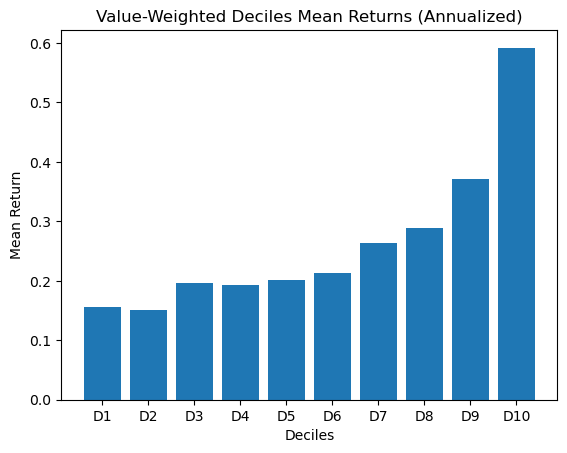

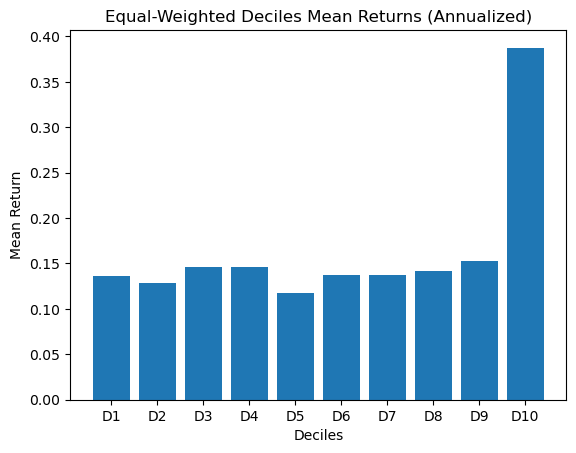

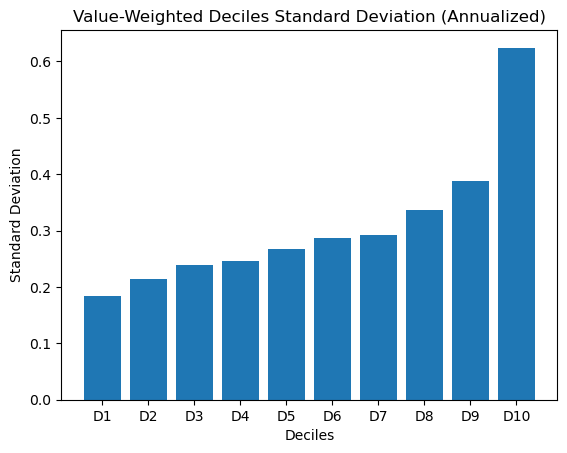

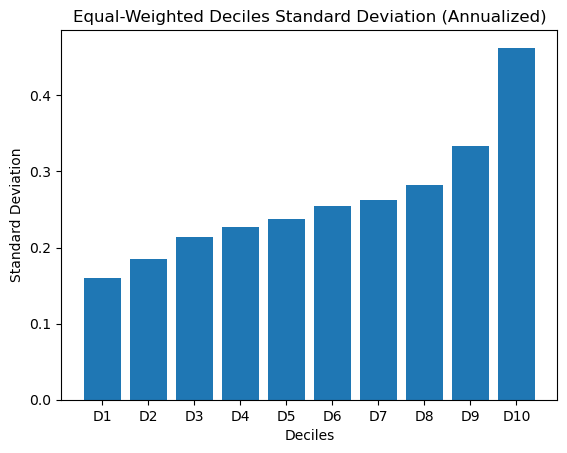

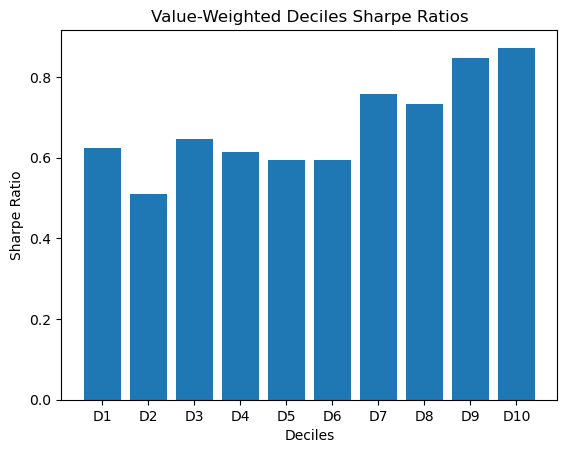

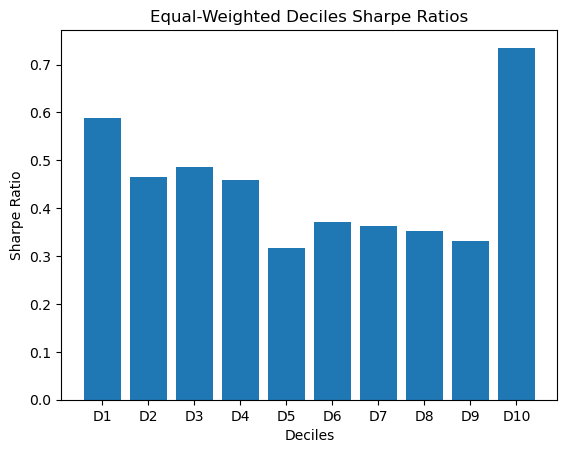

In [464]:
# Calculate standard deviations
vw_ret_std = ret_vw.groupby('IV_Q')['IV_ret_vw'].std()
ew_ret_std = ret_ew.groupby('IV_Q')['Rn'].std()

# Calculate Sharpe Ratios

# compute the risk-free rate
rf = data.groupby(['date', 'IV_Q'])['rf'].mean().reset_index()

# compute the excess returns
ret_vw['excess'] = ret_vw['IV_ret_vw'] - rf['rf']
ret_ew['excess'] = ret_ew['Rn'] - rf['rf']

# compute the Sharpe Ratios
vw_sharpe_ratio = ret_vw.groupby('IV_Q')['excess'].mean() / vw_ret_std
ew_sharpe_ratio = ret_ew.groupby('IV_Q')['excess'].mean() / ew_ret_std


# 5. Plot Histograms
deciles = ['D' + str(x) for x in np.arange(1, 11)]

directory = 'Plots/Part5/'
#save plots
# Plot VW mean returns
plt.bar(deciles, vw_ret_mean * 12)
plt.title('Value-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.show()

# Plot EW mean returns
plt.bar(deciles, ew_ret_mean * 12)
plt.title('Equal-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.show()

# Plot VW standard deviations
plt.bar(deciles, vw_ret_std * np.sqrt(12))
plt.title('Value-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.show()

# Plot EW standard deviations
plt.bar(deciles, ew_ret_std * np.sqrt(12))
plt.title('Equal-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.show()

# Plot VW Sharpe ratios
plt.bar(deciles, vw_sharpe_ratio * np.sqrt(12))
plt.title('Value-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.show()

# Plot EW Sharpe ratios
plt.bar(deciles, ew_sharpe_ratio * np.sqrt(12))
plt.title('Equal-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.show()

### Factor creation

Equally weighted factor strategy

In [465]:
# 1. Compute the long and short legs of the strategy
long_leg = data[data['IV_Q'] >= 7].groupby('date')['Rn'].mean().reset_index()
short_leg = data[data['IV_Q'] < 3].groupby('date')['Rn'].mean().reset_index()

# 2. Compute the excess returns
rf = data.groupby(['date', 'IV_Q'])['rf'].mean().reset_index()

long_leg['excess'] = long_leg['Rn'] - rf['rf']
short_leg['excess'] = short_leg['Rn'] - rf['rf']

# 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
long_mean = long_leg['Rn'].mean() * 12
short_mean = short_leg['Rn'].mean() *12

long_mean_e = long_leg['excess'].mean() *12
short_mean_e = short_leg['excess'].mean() * 12

long_std = long_leg['Rn'].std() * np.sqrt(12)
short_std = short_leg['Rn'].std() * np.sqrt(12)

long_sharpe_ratio = long_mean_e / long_std
short_sharpe_ratio = short_mean_e / short_std

# Long minus short factor strategy
factor = long_leg.set_index("date") - short_leg.set_index("date")
factor = factor.reset_index()
factor['excess'] = factor['Rn'] - rf['rf']

factor_mean = factor['Rn'].mean() * 12
factor_mean_e = factor['excess'].mean() * 12
factor_std = factor['Rn'].std() * np.sqrt(12)
factor_sharpe_ratio = factor_mean_e / factor_std

# 4. Print the results
print('Long Leg Mean Return:', long_mean)
print('Short Leg Mean Return:', short_mean)
print('Long Leg Standard Deviation:', long_std)
print('Short Leg Standard Deviation:', short_std)
print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
print('Factor Mean Return:', factor_mean)
print('Factor Standard Deviation:', factor_std)
print('Factor Sharpe Ratio:', factor_sharpe_ratio)

Long Leg Mean Return: 0.22137642261569485
Short Leg Mean Return: 0.13860060156736886
Long Leg Standard Deviation: 0.3198908586551864
Short Leg Standard Deviation: 0.1768489604467985
Long Leg Sharpe Ratio: 0.5170267450220153
Short Leg Sharpe Ratio: 0.4671574441587746
Factor Mean Return: 0.08277582104832598
Factor Standard Deviation: 0.2231652550820465
Factor Sharpe Ratio: 0.12005241512873421


Save factor for our investing strategy

In [466]:
import scipy.stats as stats

# Test if the factor strategy has an average return that is statistically significantly different from zero

# 1. Compute the t-statistic
t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

# 2. Compute the p-value
p_value = 1 - stats.norm.cdf(t_stat)

# 3. Print the results
print('T-Statistic:', t_stat)
print('P-Value:', p_value)

# 4. Check if the p-value is less than 0.05
if p_value < 0.05:
    print('The factor strategy has an average return that is statistically significantly different from zero.')
else:
    print('The factor strategy does not have an average return that is statistically significantly different from zero.')


T-Statistic: 9.434720913590494
P-Value: 0.0
The factor strategy has an average return that is statistically significantly different from zero.


Value weighted factor strategy

In [467]:
#1. Compute the long and short legs of the strategy
vw_long_leg = data[data['IV_Q'] >= 7].groupby('date')['IV_ret_vw'].sum().reset_index()
vw_short_leg = data[data['IV_Q'] < 3].groupby('date')['IV_ret_vw'].sum().reset_index()

# 2. Compute the excess returns
rf = data.groupby(['date', 'IV_Q'])['rf'].mean().reset_index()

vw_long_leg['excess'] = vw_long_leg['IV_ret_vw'] - rf['rf']
vw_short_leg['excess'] = vw_short_leg['IV_ret_vw'] - rf['rf']

# 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
long_mean = vw_long_leg['IV_ret_vw'].mean() * 12
short_mean = vw_short_leg['IV_ret_vw'].mean() * 12

long_mean_e = vw_long_leg['excess'].mean() * 12
short_mean_e = vw_short_leg['excess'].mean() * 12

long_std = vw_long_leg['IV_ret_vw'].std() * np.sqrt(12)
short_std = vw_short_leg['IV_ret_vw'].std() * np.sqrt(12)

long_sharpe_ratio = long_mean_e / long_std
short_sharpe_ratio = short_mean_e / short_std

# Long minus short factor strategy
factor = vw_long_leg.set_index("date") - vw_short_leg.set_index("date")
factor = factor.reset_index()
factor['excess'] = factor['IV_ret_vw'] - rf['rf']

factor_mean = factor['IV_ret_vw'].mean()
factor_mean_e = factor['excess'].mean()
factor_std = factor['IV_ret_vw'].std()
factor_sharpe_ratio = factor_mean_e / factor_std

# 4. Print the results
print('Long Leg Mean Return:', long_mean)
print('Short Leg Mean Return:', short_mean)
print('Long Leg Standard Deviation:', long_std)
print('Short Leg Standard Deviation:', short_std)
print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
print('Factor Mean Return:', factor_mean)
print('Factor Standard Deviation:', factor_std)
print('Factor Sharpe Ratio:', factor_sharpe_ratio)

Long Leg Mean Return: 1.1699535847651337
Short Leg Mean Return: 0.5039911068352706
Long Leg Standard Deviation: 1.036581525075468
Short Leg Standard Deviation: 0.5863889520936467
Long Leg Sharpe Ratio: 1.0746567101715665
Short Leg Sharpe Ratio: 0.7640096424613697
Factor Mean Return: 0.05549687316082191
Factor Standard Deviation: 0.2321441085733804
Factor Sharpe Ratio: 0.2189653474572037


In [468]:
# Test if the factor strategy has an average return that is statistically significantly different from zero

# 1. Compute the t-statistic
t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

# 2. Compute the p-value
p_value = 1 - stats.norm.cdf(t_stat)

# 3. Print the results
print('T-Statistic:', t_stat)
print('P-Value:', p_value)

# 4. Check if the p-value is less than 0.05
if p_value < 0.05:
    print('The factor strategy has an average return that is statistically significantly different from zero.')
else:
    print('The factor strategy does not have an average return that is statistically significantly different from zero.')

T-Statistic: 6.08083176757916
P-Value: 5.978034733900017e-10
The factor strategy has an average return that is statistically significantly different from zero.


In [469]:
# Merge factor dataframe with strat dataframe

strat = strat.merge(factor[['date','IV_ret_vw']], on='date', how='left')

# Drop all nans
strat = strat.dropna()

In [470]:
# rename columns to IV and MOM
strat = strat.rename(columns={'IV_ret_vw':'IV','MOM_ret_vw':'MOM'})
strat

,date,rf,BAB2,MOM,IV
35,1970-02-01,0.005253,-0.002716,-0.026317,0.045116
36,1970-03-01,0.005345,0.044937,0.038137,-0.372245
37,1970-04-01,0.005427,-0.125513,0.161320,-0.374462
38,1970-05-01,0.005257,-0.065251,0.099705,-0.045922
39,1970-06-01,0.004942,0.022253,0.185078,0.213157
...,...,...,...,...,...
677,2023-08-01,0.004463,0.003286,0.095216,-0.058749
678,2023-09-01,0.004472,-0.032719,-0.060954,0.165349
679,2023-10-01,0.004475,0.041248,-0.177022,0.104547
680,2023-11-01,0.004455,0.020435,0.053404,-0.091483


In [471]:
strat.to_csv('strat.csv', sep=';',index=False) # export data

In [472]:
# read csv
strat = pd.read_csv('strat.csv', sep=';')

# 6 Optimal Fund Portfolio Return (STRAT)

In [473]:
# Equal weight strategy
strat['STRAT1'] = (strat['BAB2'] + strat['IV'] + strat['MOM'])/3

# Window size equal to data length
number_of_rows = len(strat)


# Risk-Parity strategy
rolling_vol = strat[['BAB2', 'IV', 'MOM']].rolling(window = 60,min_periods=36).std()
weights = 1 / rolling_vol
# Normalize the weights
weights = weights.div(weights.sum(axis=1), axis=0)
strat['STRAT2'] = (weights['BAB2'] * strat['BAB2'] + weights['IV'] * strat['IV'] + weights['MOM'] * strat['MOM'])

# Mean-variance optimal combination
rolling_mean = strat[['BAB2', 'IV', 'MOM']].rolling(window = 60, min_periods=36).mean()
rolling_cov = strat[['BAB2', 'IV', 'MOM']].rolling(window = 60, min_periods=36).cov()

# w_tan = Cov^(-1) * (mu - Rf * 1) / 1.T * Cov^(-1) * (mu - Rf * 1)

# Iterate over the rolling windows
optimal_weights = []
for i in range(number_of_rows):
    mu = rolling_mean.iloc[i].values
    cov = rolling_cov.loc[rolling_cov.index.get_level_values(0) == i].droplevel(0)
    ones = np.ones(len(mu))
    rf = strat['rf'].iloc[i]
    w_tan = np.linalg.inv(cov).dot((mu - rf * ones)) / (ones.T.dot(np.linalg.inv(cov).dot((mu - rf * ones))))
    optimal_weights.append(w_tan)

optimal_weights = pd.DataFrame(optimal_weights, columns = ['BAB2', 'IV', 'MOM'])
strat['STRAT3'] = (optimal_weights['BAB2'] * strat['BAB2'] + optimal_weights['IV'] * strat['IV'] + optimal_weights['MOM'] * strat['MOM'])

In [474]:
# Calculate the annualized volatility and mean of the STRAT1, STRAT2, and STRAT3 strategies
strat1_mean = strat['STRAT1'].mean() * 12
strat1_std = strat['STRAT1'].std() * np.sqrt(12)
excess_strat1 = strat['STRAT1'] - strat['rf']
strat1_sharpe = excess_strat1.mean() / strat["STRAT1"].std() * np.sqrt(12)

strat2_mean = strat['STRAT2'].mean() * 12
strat2_std = strat['STRAT2'].std() * np.sqrt(12)
excess_strat2 = strat['STRAT2'] - strat['rf']
strat2_sharpe = excess_strat2.mean() / strat["STRAT2"].std() * np.sqrt(12)

strat3_mean = strat['STRAT3'].mean() * 12
strat3_std = strat['STRAT3'].std() * np.sqrt(12)
excess_strat3 = strat['STRAT3'] - strat['rf']
strat3_sharpe = excess_strat3.mean() / strat["STRAT3"].std() * np.sqrt(12)

# Print the results
print('Equal Weighted Strategy:')
print('Mean:', strat1_mean)
print('Standard Deviation:', strat1_std)
print('Sharpe Ratio:', strat1_sharpe)
print("\n")

print('Risk-Parity Strategy:')
print('Mean:', strat2_mean)
print('Standard Deviation:', strat2_std)
print('Sharpe Ratio:', strat2_sharpe)
print("\n")

print('Mean-Variance Optimal Strategy:')
print('Mean:', strat3_mean)
print('Standard Deviation:', strat3_std)
print('Sharpe Ratio:', strat3_sharpe)

Equal Weighted Strategy:
Mean: 0.25091928811435593
Standard Deviation: 0.3310859279455267
Sharpe Ratio: 0.6294606515552125


Risk-Parity Strategy:
Mean: 0.19304488485206134
Standard Deviation: 0.19678413007133316
Sharpe Ratio: 0.7657608245332258


Mean-Variance Optimal Strategy:
Mean: 0.48352132854740876
Standard Deviation: 3.499811533174372
Sharpe Ratio: 0.12605422240942277


In [475]:
# Now find c such that the average annual volatility of the fund is 10% in each case
c1 = 0.1 / strat1_std
c2 = 0.1 / strat2_std
c3 = 0.1 / strat3_std

# Calculate the fund returns
strat['fund1'] = strat['rf'] + c1 * strat['STRAT1']
strat['fund2'] = strat['rf'] + c2 * strat['STRAT2']
strat['fund3'] = strat['rf'] + c3 * strat['STRAT3']

# Calculate the annualized volatility and mean of the fund returns
fund1_mean = strat['fund1'].mean() * 12
fund1_std = strat['fund1'].std() * np.sqrt(12)
excess_fund1 = strat['fund1'] - strat['rf']
fund1_sharpe = excess_fund1.mean() / strat["fund1"].std() * np.sqrt(12)

fund2_mean = strat['fund2'].mean() * 12
fund2_std = strat['fund2'].std() * np.sqrt(12)
excess_fund2 = strat['fund2'] - strat['rf']
fund2_sharpe = excess_fund2.mean() / strat["fund2"].std() * np.sqrt(12)

fund3_mean = strat['fund3'].mean() * 12
fund3_std = strat['fund3'].std() * np.sqrt(12)
excess_fund3 = strat['fund3'] - strat['rf']
fund3_sharpe = excess_fund3.mean() / strat["fund3"].std() * np.sqrt(12)

# Print the results

# Print the c
print('c1:', c1)
print('c2:', c2)
print('c3:', c3)
print("\n")

print('Equal Weighted Fund:')
print('Mean:', fund1_mean)
print('Standard Deviation:', fund1_std)
print('Sharpe Ratio:', fund1_sharpe)
print("\n")

print('Risk-Parity Fund:')
print('Mean:', fund2_mean)
print('Standard Deviation:', fund2_std)
print('Sharpe Ratio:', fund2_sharpe)
print("\n")

print('Mean-Variance Optimal Fund:')
print('Mean:', fund3_mean)
print('Standard Deviation:', fund3_std)
print('Sharpe Ratio:', fund3_sharpe)


c1: 0.3020363946620314
c2: 0.5081710601548537
c3: 0.028572967158976923


Equal Weighted Fund:
Mean: 0.11830048132222615
Standard Deviation: 0.10042814872434674
Sharpe Ratio: 0.754636604337312


Risk-Parity Fund:
Mean: 0.14045513094632733
Standard Deviation: 0.10022090438338695
Sharpe Ratio: 0.9788359464156374


Mean-Variance Optimal Fund:
Mean: 0.05617094619483366
Standard Deviation: 0.10151487637516837
Sharpe Ratio: 0.1360947235968801


In [476]:
filename = f"{industry_column_name}.csv"
strat.drop(columns=['STRAT1','STRAT3','fund1', 'fund3']).to_csv(filename, sep=';', index=False)

# 7 Performance and risk analysis for the Fund strategy